# Analysis of mouse single cell hematopoietic populations - Analysis of ATAC-Seq profiles

__Author__: Elisabeth F. Heuston

## Purpose

Single cell transcriptional and clustering analysis of LSK, CMP, MEP, and GMP data presented in Heuston et al., 2021  

This notebook contains the workflow to analyze ATAC-Seq data and pertains to:
* Figures 5C, 5E
* Supplemental Figure 7D  

Raw data for this publication are available to download from the GEO Project GSE168260 at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE168260  

## Workbook setup

### Import python3.7 modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.colorbar
import pandas as pd
from pandas import ExcelWriter, ExcelFile
from pybedtools import BedTool
import os, re, glob, csv, warnings
import seaborn as sns
from pathlib import Path

warnings.filterwarnings("ignore")

### Functions

#### closestbed_between_lists

In [2]:
def closestbed_between_lists(list_a, list_b, outdir = "./", verbose = True):
    ''' 
    For each feature in list_a, find the closest feature in list_b.
    
    closestBed -a list_a[x] -b list_b[y] -D "ref" -t "all"
    
    Function automatically removes files in list_b from list_a
    '''
    

    for i in range(0, len(list_a)):
        for j in range(0, len(list_b)):
            
            a_file = BedTool(list_a[i]).sort()
            a_file_name = str(list_a[i]).rsplit(".", 1)[0]

            b_file = BedTool(list_b[j]).sort()
            b_file_name =  str(list_b[j]).rsplit(".", 1)[0]
            
            if verbose == True:
                print("Starting with features in", list_a[i], "and finding the closest feature from", list_b[j])
            
            # Do closestBed
            a_file.closest(b_file, D = "ref", t = "all").saveas(''.join((outdir, a_file_name, "_closest_", b_file_name, ".bed")))
            



#### gene_filter

In [3]:
def gene_filter(df, df_col):
    new_df = df[~df[df_col].str.contains('|'.join(('^Gm\d{1,}a?$', 'Rik', '^[A-Z]{2,}', 'n-')))]
    return new_df

#### create table of averages

In [4]:
def create_column_dictionary(counts_table, ignore_col):
    column_dict = {}
    for name in counts_table.columns:
        if name not in ignore_col:
            m = re.split('(_r\d+)$', name)
            if m[0] in column_dict:
                pass
            else:
                column_dict.setdefault(m[0], [])
            column_dict[m[0]].append(name)
    return column_dict
    print("Created column dictionary")
    

def create_table_of_averages(counts_table, ignore_col):
    column_dict = create_column_dictionary(counts_table, ignore_col)
    table_of_averages = pd.DataFrame()
    for celltype in column_dict.keys():
        table_of_averages[celltype + 'avg'] = counts_table[column_dict[celltype]].mean(axis = 1)
    table_of_averages = pd.concat([table_of_averages, counts_table[ignore_col]], axis = 1)
    
    return table_of_averages

#### read_bedfiles_to_dict

In [5]:
def read_bedfiles_to_dict(bed_list, entry_name_split = '\.bed', bedfile_columns = None, float_cols = None, int_cols = None):
    '''
    Given a list of (one or more) bed files, read them into a single dictionary
    
    bed_list: list of bed files
    
    entry_name_split: where to re.split the file name (takes the first argument)
    
    Optional arguments:
    
    bedfile_columns: list of column names (must match number of columns)
    
    float_cols: list of columns to define as float64 (defined by column name)
    
    int_cols: list of columns to define as integers (defined by column name)
    '''
    
    bedlist_dict = {}
    split_str = re.compile(entry_name_split)
    
    for bedfile in bed_list:
        entry_name = re.split(split_str, bedfile)[0]
        bed_df = BedTool(bedfile).to_dataframe()
        bed_df = bed_df.replace('.', np.nan).dropna(axis = 'index', how = 'any')
        bedlist_dict[entry_name] = bed_df
        
        # change column names and data types if not None
        if bedfile_columns is not None:
            bedlist_dict[entry_name].columns = bedfile_columns
        if float_cols is not None:
            bedlist_dict[entry_name][float_cols] = bedlist_dict[entry_name][float_cols].astype('float64')
        if int_cols is not None:
            bedlist_dict[entry_name][int_cols] = bedlist_dict[entry_name][int_cols].astype('int')            
    return bedlist_dict

#### convert_to_bed6

In [6]:
def convert_to_bed6(bedFile_List):
    for bedFile in bedFile_List:
        bedFile = bedFile.split('/')[-1]
        bedDf = BedTool(bedFile).to_dataframe()
        bedDf["UniqueID"] = ['peak_'+str(i) for i in range(len(bedDf))]
        bedDf['File'] = bedFile.split('.bed')[0]
        bedDf['Strand'] = '+'
        print("Saving", "".join([bedFile, '6']))
        BedTool.from_dataframe(bedDf).saveas("".join([bedFile, '6']))

#### motif_analysis

In [7]:
def motif_analysis(dirlist, homerdir_match = '_HOMER', columnName_split = '_HOMER', numberResults = None, TF_list = None, qval = 0.05, TF_list_only = False):
    
    homerdir_match = re.compile(homerdir_match)
    homer_table = pd.DataFrame()

    for homerdir in os.listdir(dirlist):
        if os.path.isdir(homerdir) and re.search(homerdir_match, homerdir):
            comparison = os.path.basename(homerdir)
            print("adding comparison", comparison)

            results_table = pd.read_table('/'.join([homerdir, "knownResults.txt"]), index_col=[0], usecols=[0,3,4], header = 0,names=["Motif Name", comparison, "qVal"])
            results_table = results_table[(results_table["qVal"] <= qval)]
            results_table = results_table[comparison].multiply(-1)
            results_table.index = results_table.index.map(lambda x: x.split("(", 1)[0])
            homer_table = homer_table.merge(results_table, left_index=True, right_index = True, how = 'outer', sort = True, copy = False)

        homer_table.rename(columns = lambda x: re.split(columnName_split, x)[0], inplace = True)
    return homer_table

# Merge all CMP subpopulation peaks

## Compare all CMP subpopulations together

### Setting up comparisons

1. Create mergedBed of all CMP subpopulations  
2. Get unique sets of peaks for each CMP subpopulation
3. Compare against canonical bulk populations

There are 15 comparisons to make.

Uniquely expressed (1):  
* C11 (not C10C3C17)
* C10 (not C11C3C17)
* C17 (not C11C10C3)
* C3 (not C11C10C17)

Shared (2):  
* C11C10 (not C3C17)
* C11C3 (not C10C17)
* C11C17 (not C10C3)
* C10C3 (not C11C17)
* C10C17 (not C11C3)
* C3C17 (not C11C10)

Shared (3):
* C10C3C17 (not C11)
* C11C3C17 (not C10)
* C11C10C17 (not C3)
* C11C10C3 (not C17)

Shared (4):
* C11C10C3C17

### Create CMP subpopulation merged peak file

1. Concatenate C10, C11, C17, and C3 bed files  
2. Sort bed file  
3. Merge peaks in bed file
4. Identify peaks from merged dataset unique to each population  

In [8]:
%%bash

cd ~/Desktop/scRNAanalysis_codetest/ATAC/
cat C10.bed C11.bed C17.bed C3.bed > allATAC_cat.bed
sortBed -i allATAC_cat.bed > allATAC_sort.bed
mergeBed -i allATAC_sort.bed > allATAC.bed

rm allATAC_*.bed

## All CMP subpopulation comparisons

In [9]:
merged_bed = 'allATAC.bed'
subpop_list = ['C10', 'C11', 'C17', 'C3']
bedfile_list = [''.join((x, '.bed')) for x in subpop_list]

In [10]:
subpop_all_overlaps = {}
merged_bed = BedTool(merged_bed)

for i in range(0, len(bedfile_list)):
    if i < len(subpop_list)-3:
        j = i + 1
        if j < len(subpop_list)-2:
            k = j + 1
            if k < len(subpop_list)-1:
                m = k + 1
                while m < len(subpop_list):
                    
                    first_bedfile = BedTool(bedfile_list[i])
                    first_bedfile_name = re.split("\.", bedfile_list[i])[0]

                    second_bedfile = BedTool(bedfile_list[j])
                    second_bedfile_name = re.split("\.", bedfile_list[j])[0]

                    third_bedfile = BedTool(bedfile_list[k])
                    third_bedfile_name = re.split("\.", bedfile_list[k])[0]

                    fourth_bedfile = BedTool(bedfile_list[m])
                    fourth_bedfile_name = re.split("\.", bedfile_list[m])[0]
                    
                    # Unique pops
                    ((((merged_bed + first_bedfile)-second_bedfile)-third_bedfile)-fourth_bedfile).saveas(''.join((first_bedfile_name,'not', second_bedfile_name, third_bedfile_name, fourth_bedfile_name, '.bed')))
                    ((((merged_bed + second_bedfile)-first_bedfile)-third_bedfile)-fourth_bedfile).saveas(''.join((second_bedfile_name,'not', first_bedfile_name , third_bedfile_name, fourth_bedfile_name, '.bed')))
                    ((((merged_bed + third_bedfile)-first_bedfile)-second_bedfile)-fourth_bedfile).saveas(''.join((third_bedfile_name,'not', first_bedfile_name, second_bedfile_name, fourth_bedfile_name, '.bed')))
                    ((((merged_bed + fourth_bedfile)-first_bedfile)-second_bedfile)-third_bedfile).saveas(''.join((fourth_bedfile_name,'not', first_bedfile_name, second_bedfile_name, third_bedfile_name, '.bed')))
                    
                    # Shared (2)
                    (((merged_bed+first_bedfile+second_bedfile)-third_bedfile)-fourth_bedfile).saveas(''.join((first_bedfile_name, second_bedfile_name, 'not', third_bedfile_name, fourth_bedfile_name, '.bed')))
                    (((merged_bed+first_bedfile+third_bedfile)-second_bedfile)-fourth_bedfile).saveas(''.join((first_bedfile_name, third_bedfile_name, 'not', second_bedfile_name, fourth_bedfile_name, '.bed')))
                    (((merged_bed+first_bedfile+fourth_bedfile)-second_bedfile)-third_bedfile).saveas(''.join((first_bedfile_name, fourth_bedfile_name, 'not', second_bedfile_name, third_bedfile_name, '.bed')))
                    (((merged_bed+second_bedfile+third_bedfile)-first_bedfile)-fourth_bedfile).saveas(''.join((second_bedfile_name, third_bedfile_name, 'not', first_bedfile_name, fourth_bedfile_name, '.bed')))
                    (((merged_bed+second_bedfile+fourth_bedfile)-first_bedfile)-third_bedfile).saveas(''.join((second_bedfile_name, fourth_bedfile_name, 'not', first_bedfile_name, third_bedfile_name, '.bed')))
                    (((merged_bed+third_bedfile+fourth_bedfile)-first_bedfile)-second_bedfile).saveas(''.join((third_bedfile_name, fourth_bedfile_name, 'not', first_bedfile_name, second_bedfile_name, '.bed')))
                    
                    # Shared (3)
                    ((merged_bed+second_bedfile+third_bedfile+fourth_bedfile)-first_bedfile).saveas(''.join((second_bedfile_name, third_bedfile_name, fourth_bedfile_name, 'not', first_bedfile_name, '.bed')))
                    ((merged_bed+first_bedfile+third_bedfile+fourth_bedfile)-second_bedfile).saveas(''.join((first_bedfile_name, third_bedfile_name, fourth_bedfile_name, 'not', second_bedfile_name, '.bed')))
                    ((merged_bed+first_bedfile+second_bedfile+fourth_bedfile)-third_bedfile).saveas(''.join((first_bedfile_name, second_bedfile_name, fourth_bedfile_name, 'not', third_bedfile_name, '.bed')))
                    ((merged_bed+first_bedfile+second_bedfile+third_bedfile)-fourth_bedfile).saveas(''.join((first_bedfile_name, second_bedfile_name, third_bedfile_name, 'not', fourth_bedfile_name, '.bed')))
                    
                    # Shared (4)
                    (merged_bed+first_bedfile+second_bedfile+third_bedfile+fourth_bedfile).saveas(''.join((first_bedfile_name, second_bedfile_name, third_bedfile_name, fourth_bedfile_name, '.bed')))
                    
                    m = m + 1
                k = k + 1
            j = j + 1
            



### Get list of peaks also in CMP

Perform intersectBed to identify peaks in each subpop comparison set that are also in CMP

In [11]:
comparelist = [x for x in os.listdir('./') if os.path.isfile(x) and re.match('^C.+C.+C.+C.+\.bed', x)]

In [12]:
merged_bed = BedTool('allATAC.bed')
first_bedfile = BedTool('CMP.bed')
first_bedfile_name = 'CMP'

for i in range(0, len(comparelist)):
    second_bedfile = BedTool(comparelist[i])
    second_bedfile_name = re.split("\.", comparelist[i])[0]

    print("Comparing CMP.bed and", comparelist[i])

    # Do intersections
    (merged_bed + first_bedfile + second_bedfile).saveas(''.join((first_bedfile_name, "and", second_bedfile_name, ".bed"))) # CMPandX

Comparing CMP.bed and C10C11C3notC17.bed
Comparing CMP.bed and C10C11C17notC3.bed
Comparing CMP.bed and C10C3notC11C17.bed
Comparing CMP.bed and C11C17C3notC10.bed
Comparing CMP.bed and C10C17C3notC11.bed
Comparing CMP.bed and C10C11C17C3.bed
Comparing CMP.bed and C10notC11C17C3.bed
Comparing CMP.bed and C11C3notC10C17.bed
Comparing CMP.bed and C17C3notC10C11.bed
Comparing CMP.bed and C11C17notC10C3.bed
Comparing CMP.bed and C10C11notC17C3.bed
Comparing CMP.bed and C3notC10C11C17.bed
Comparing CMP.bed and C17notC10C11C3.bed
Comparing CMP.bed and C11notC10C17C3.bed
Comparing CMP.bed and C10C17notC11C3.bed


### Count genes in the table

Create two new dictionaries for plotting data in Supplemental Figure 7C  
> num_genes = number of genes in each comparison  
> pct_CMP = percentage of genes in the comparison that are also expressed above the count threshold in CMP

Final figure will be a 4x4 grid where each box represents one of the comparisons

"keyorder" specifies which comparison goes in which box

In [13]:
keyorder = np.array([['C10', 'C10C11', 'C11', np.nan],
        ['C10C17', 'C10C11C17', 'C11C17', 'C17'],
        ['C10C17C3', 'C10C11C17C3', 'C11C17C3', 'C17C3'],
        ['C10C3', 'C10C11C3', 'C11C3', 'C3']
       ], dtype = 'object')


Assign values from "num_genes" and "pct_CMP" to each value in the box

In [14]:
# file_list = [x for x in os.listdir('./') if os.path.isfile(x) and re.match('C.+C.+\.bed', x)]

comp_dict = {}
num_genes = {}

num_list = []
pct_list = []

for bedfile in [x for x in os.listdir('./') if os.path.isfile(x) and re.match('C.+C.+\.bed', x)]:
    if bedfile.startswith('CMP'):
        pct_list.append(bedfile)
    elif not bedfile.startswith('CMP'):
        num_list.append(bedfile)
    else:
        print(bedfile, 'was not processed into a list')
        
read_dict = read_bedfiles_to_dict(num_list)
dict_keys = read_dict.keys()

for key in dict_keys:
    new_key = key.split('not')[0]
    comp_dict[new_key] = read_dict[key]
print(comp_dict.keys())

dict_keys(['C10C11C3', 'C10C11C17', 'C10C3', 'C11C17C3', 'C10C17C3', 'C10C11C17C3', 'C10', 'C11C3', 'C17C3', 'C11C17', 'C10C11', 'C3', 'C17', 'C11', 'C10C17'])


In [15]:
graph_value = keyorder.copy()

for beddf in comp_dict.keys():
    position = np.where(graph_value == beddf)
    graph_value[position] = comp_dict[beddf].shape[0] # shape [0] = number of rows in df


graph_color = keyorder.copy()

for bedfile in pct_list:
    file = open(bedfile, "r")
    line_count = 0
    for line in file:
        if line != "\n":
            line_count += 1
    file.close()
        
    comparison = re.search('(C\d+.*?)(?=[not.* | \.bed])', bedfile)[0]
    position = np.where(graph_color == comparison) # position is same for graph_color and graph_value
    graph_color[position] = line_count
            
graph_color = graph_color/graph_value*100 # percentage of subpop-specific peaks which are also in CMP

graph_color = graph_color.astype('float') 
graph_color = np.rint(graph_color)
graph_value = graph_value.astype('float') 

#### Supplemental Figure 7D

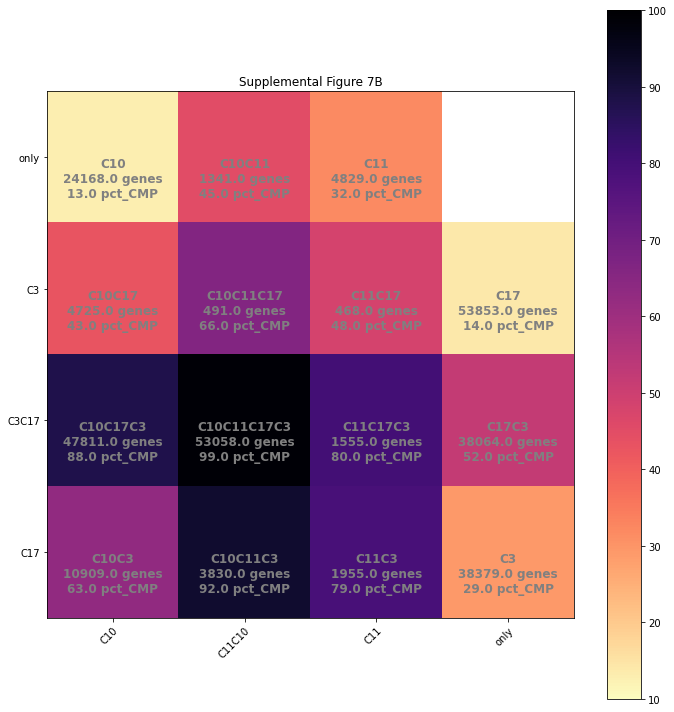

In [16]:
xaxis = ['C10', 'C11C10', 'C11', 'only']
yaxis = ['only', 'C3', 'C3C17', 'C17']

fig, ax = plt.subplots(figsize = (10, 10))
im = ax.imshow(graph_color, cmap='magma_r', vmin= 10, vmax = 100)
fig.colorbar(im)

# Show all ticks...
ax.set_xticks(np.arange(len(xaxis)))
ax.set_yticks(np.arange(len(yaxis)))
# Label them 
ax.set_xticklabels(xaxis)
ax.set_yticklabels(yaxis)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(xaxis)):
    for j in range(len(yaxis)):
        if not str(graph_value[i, j]) == 'nan':
            text = ax.text(j, i, ''.join((keyorder[i,j], '\n', str(graph_value[i, j]), ' genes', '\n', str(graph_color[i,j]), ' pct_CMP', '\n')),
                           ha="center", va="top", color="grey", fontweight = 'bold', fontsize = 'large')

ax.set_title("Supplemental Figure 7B")
fig.tight_layout()
plt.show() # Note that in the text, figure is rotated 270 degrees (diamond format)

### HOMER

In [17]:
bedfile_list = [x for x in glob.glob('*.bed') if re.match('C\d{1,2}not.+', x)]
convert_to_bed6(bedfile_list)

Saving C10notC11C17C3.bed6
Saving C3notC10C11C17.bed6
Saving C17notC10C11C3.bed6
Saving C11notC10C17C3.bed6


In [18]:
bed6_list = glob.glob('*.bed6')
for bedfile in bed6_list:
    print('Running Homer findMotifsGenome.pl on', bedfile)
    homer_command = 'findMotifsGenome.pl ' + bedfile + ' mm10 ' + bedfile.rsplit('.', 1)[0] + '_HOMER' + ' -nomotif -p 4 '
    print(homer_command)
    os.system(homer_command)
    print('\t...done!')

Running Homer findMotifsGenome.pl on C11notC10C17C3.bed6
findMotifsGenome.pl C11notC10C17C3.bed6 mm10 C11notC10C17C3_HOMER -nomotif -p 4 
	...done!
Running Homer findMotifsGenome.pl on C17notC10C11C3.bed6
findMotifsGenome.pl C17notC10C11C3.bed6 mm10 C17notC10C11C3_HOMER -nomotif -p 4 
	...done!
Running Homer findMotifsGenome.pl on C10notC11C17C3.bed6
findMotifsGenome.pl C10notC11C17C3.bed6 mm10 C10notC11C17C3_HOMER -nomotif -p 4 
	...done!
Running Homer findMotifsGenome.pl on C3notC10C11C17.bed6
findMotifsGenome.pl C3notC10C11C17.bed6 mm10 C3notC10C11C17_HOMER -nomotif -p 4 
	...done!


In [19]:
PTFs = ["Gata2", "Pf4", "Meis1", "Itga2b", "Fli1", "Gata1", "EKLF", "Zfpm1", "Tal1", "NF-E2", "PU.1", "Elf4", "GATA:SCL", "SCL", "IRF8"]
homer_table = motif_analysis(dirlist = './', columnName_split='not', homerdir_match= '_HOMER', numberResults=20, qval=0.05, TF_list = PTFs, TF_list_only=True)

adding comparison C10notC11C17C3_HOMER
adding comparison C3notC10C11C17_HOMER
adding comparison C11notC10C17C3_HOMER
adding comparison C17notC10C11C3_HOMER


#### Figure 5C

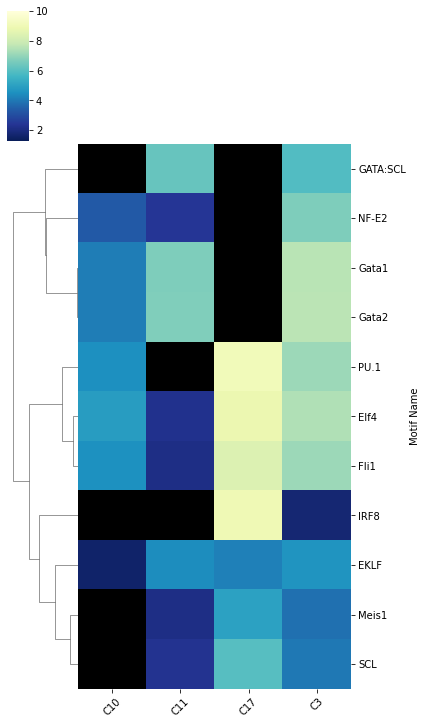

In [20]:
modcmap = plt.cm.YlGnBu_r
modcmapList = [modcmap(i) for i in range(modcmap.N)]
modcmapList[0] = (0,0,0,1)
modcmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm', modcmapList, modcmap.N)

homer_table = homer_table[['C10', 'C11', 'C17', 'C3']] # Set column order

homer_hmPTF = sns.clustermap(np.log(homer_table[homer_table.index.isin(PTFs)]).fillna(0), figsize = (6,10), vmin = 1.3, vmax = 10, cmap = modcmap, col_cluster=False)
plt.setp(homer_hmPTF.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis
plt.setp(homer_hmPTF.ax_heatmap.get_xticklabels(), rotation=45) # For x axis
plt.show()
# homer_hmPTF.savefig(''.join([outname, '-PTFs', title_suffix, '.png']), transparent = True, dpi=400)

# Correlate ATAC-Seq peaks with ccRE

The list of ccRE-gene correlations are available through http://usevision.org.  The entire list can be downloaded at:


https://ccre-filter.bx.psu.edu/mouse_allChr_wTAD_weRP_wAllComp_071819.txt

## Generate new ccRE table with symbol:ens format with no gene_filter

### Read in ccRE table

In [21]:
ccre_table = pd.read_csv("mouse_allChr_wTAD_weRP_wAllComp_071819.txt", sep = "\t", na_values='.', usecols = 
                         ['chr',
                         'ccRE_start',
                         'ccRE_end',
                         'pk',
                         'tss',
                         'geneID',
                         'correlation',
                         'SameCompartment']
                        )
ccre_table[['tss', 'ccRE_start', 'ccRE_end', 'correlation']] = ccre_table[['tss', 'ccRE_start', 'ccRE_end', 'correlation']].apply(pd.to_numeric)
ccre_table = ccre_table[ccre_table['SameCompartment'] == 'Yes']
ccre_table.drop('SameCompartment', inplace = True, axis = 1)
ccre_table = ccre_table[ccre_table["correlation"] > 0].reset_index(drop = True)

### Assign each ccRE to single gene

#### Define & apply masks for ccRE_df 

In [22]:
ccre_table = ccre_table.sort_values('correlation', ascending = False)

mask1 = ccre_table['correlation'] == ccre_table.groupby('pk', sort = False)['correlation'].transform('max')
mask2 = ccre_table.duplicated('pk')

ccre_table = ccre_table[~(mask2 & ~mask1)]
ccre_table = ccre_table.reset_index(drop = True)

del mask1
del mask2

In [23]:
ccre_table.head(2)

,chr,tss,geneID,ccRE_start,ccRE_end,correlation,pk
0,chr12,113654967,Gm17309:ENSMUSG00000090395.1,113355866,113356098,0.999996,chr12_113355866_113356098
1,chr12,113654967,Gm17309:ENSMUSG00000090395.1,113931850,113932220,0.999996,chr12_113931850_113932220


#### Confirm all ccREs are unique and assigned to 1 gene

In [24]:
print(ccre_table.shape[0], ' entries; \n\t\t',
      len(ccre_table['geneID'].unique())," unique genes ",
      "(", round(len(ccre_table['geneID'].unique())/len(ccre_table)*100), "% of all genes); ",
      len(ccre_table['pk'].unique()), " unique ccREs ",
      "(", round(len(ccre_table['pk'].unique())/len(ccre_table)*100), "% of all ccREs); ",
      "min_eRP: ", round(min(ccre_table['correlation']), 3),
      '\n',
      sep=''
     )

183645 entries; 
		28068 unique genes (15% of all genes); 183597 unique ccREs (100% of all ccREs); min_eRP: 0.0



## Closest bed between ccRE and ATACPeaks - unqCMP subpopulation

### Assign closest ccRE

In [25]:
bedfile_list = [x for x in os.listdir('./') if x.startswith(('C10not', 'C11not', 'C17not', 'C3not', 'CMP.')) and x.endswith('bed')]
reference_list = BedTool.from_dataframe(ccre_table[["chr", "ccRE_start", "ccRE_end", "geneID", "tss", "correlation"]]).sort()

In [26]:
for i in range(0, len(bedfile_list)):
    a_file = BedTool(bedfile_list[i]).sort()
    a_file_name = str(bedfile_list[i]).rsplit(".", 1)[0]

    b_file = reference_list
    b_file_name = 'ccre'

    print("Starting with features in", bedfile_list[i], "and finding the closest feature from", b_file_name)

    # Do closestBed
    a_file.closest(b_file, D = "ref", t = "all").saveas(''.join((a_file_name, "_closest_", b_file_name, ".bed")))




Starting with features in C10notC11C17C3.bed and finding the closest feature from ccre
Starting with features in C3notC10C11C17.bed and finding the closest feature from ccre
Starting with features in C17notC10C11C3.bed and finding the closest feature from ccre
Starting with features in C11notC10C17C3.bed and finding the closest feature from ccre
Starting with features in CMP.bed and finding the closest feature from ccre


### Read in closestBed dictionary

In [27]:
closestbed_list = [x for x in os.listdir('./') if x.endswith('_ccre.bed')]

closest_dict = {}
    
for bedfile in closestbed_list:
    entry_name = re.split('\.', bedfile)[0]
    bed_df = BedTool(bedfile).to_dataframe(low_memory = False)
    bed_df = bed_df.replace('.', np.nan).dropna(axis = 'index', how = 'any')
    closest_dict[entry_name] = bed_df
    # change column names and data types
    closest_dict[entry_name].columns = ["ATACpk_chrom", "ATACpk_start", "ATACpk_stop", "ccRE_chrom", "ccRE_start", "ccRE_end", "geneID", 'tss', 'correlation', "Distance"]
    float_cols = ["correlation"]
    int_cols = ["ATACpk_start", "ATACpk_stop", "ccRE_start", "ccRE_end", "tss", "Distance"]
    closest_dict[entry_name][float_cols] = closest_dict[entry_name][float_cols].astype('float64')
    closest_dict[entry_name][int_cols] = closest_dict[entry_name][int_cols].astype('int')    

#### shorten key names

In [28]:
key_list = list(closest_dict.keys())

for key in key_list:
    short_key = re.split('not', key)[0]
    closest_dict[short_key] = closest_dict.pop(key)

### Set geneID as versionless ensembl

In [29]:
for df in closest_dict.keys():
    closest_dict[df]['geneID'] = closest_dict[df]['geneID'].apply(lambda x: re.split(':', x)[1]).apply(lambda x: re.split('\.', x)[0])

In [30]:
closest_dict['C10'].head()

,ATACpk_chrom,ATACpk_start,ATACpk_stop,ccRE_chrom,ccRE_start,ccRE_end,geneID,tss,correlation,Distance
0,chr1,3764890,3765040,chr1,3672092,3672710,ENSMUSG00000103161,3595903,0.760235,-92181
1,chr1,4058920,4059070,chr1,3915099,3915356,ENSMUSG00000064842,3102016,0.999988,-143565
2,chr1,4202238,4202388,chr1,4412516,4412820,ENSMUSG00000025900,4409241,0.551332,210129
3,chr1,4352386,4352536,chr1,4412516,4412820,ENSMUSG00000025900,4409241,0.551332,59981
4,chr1,4414997,4415147,chr1,4414714,4415105,ENSMUSG00000025900,4409241,0.514518,0


In [31]:
for key in closest_dict.keys():
    print(key)
    print('initial shape', closest_dict[key].shape)
    closest_dict[key]['abs_dist'] = abs(closest_dict[key]['Distance'])
    closest_dict[key].sort_values(by = ['abs_dist', 'correlation'], inplace = True)
    closest_dict[key].drop_duplicates(inplace = True, ignore_index=True, subset = ['geneID'])
    closest_dict[key].drop('abs_dist', axis = 1, inplace = True)
    print('final shape', closest_dict[key].shape)

C17
initial shape (53977, 10)
final shape (17100, 10)
C10
initial shape (24285, 10)
final shape (12588, 10)
C11
initial shape (4862, 10)
final shape (3731, 10)
C3
initial shape (38493, 10)
final shape (14564, 10)
CMP_closest_ccre
initial shape (198853, 10)
final shape (26331, 10)


In [32]:
for key in closest_dict.keys():
    print(closest_dict[key].shape[0], ' number of peaks at distance = 0: ', len(closest_dict[key][closest_dict[key]['Distance'] == 0]))

17100  number of peaks at distance = 0:  8932
12588  number of peaks at distance = 0:  5583
3731  number of peaks at distance = 0:  2800
14564  number of peaks at distance = 0:  8140
26331  number of peaks at distance = 0:  25774


# Correlate ATAC and RNA

## Define TopN eRPs

In [33]:
erp_dict = {}

erp_list = [0.5, 1]

for topn in erp_list:
    erp_dict[''.join(('eRP', str(topn)))] = {}

for key in closest_dict.keys():
    comparison = re.split('_', key)[0]
    for topn in erp_list:
        table_title = '_'.join((comparison, ''.join(('eRP', str(topn)))))
        n = round(len(closest_dict[key])*topn)
        erp_dict[''.join(('eRP', str(topn)))][table_title]  = closest_dict[key].nlargest(n, 'correlation')
        print(table_title, ' size before: ', closest_dict[key].shape[0], '; size now: ', erp_dict[''.join(('eRP', str(topn)))][table_title].shape[0])

C17_eRP0.5  size before:  17100 ; size now:  8550
C17_eRP1  size before:  17100 ; size now:  17100
C10_eRP0.5  size before:  12588 ; size now:  6294
C10_eRP1  size before:  12588 ; size now:  12588
C11_eRP0.5  size before:  3731 ; size now:  1866
C11_eRP1  size before:  3731 ; size now:  3731
C3_eRP0.5  size before:  14564 ; size now:  7282
C3_eRP1  size before:  14564 ; size now:  14564
CMP_eRP0.5  size before:  26331 ; size now:  13166
CMP_eRP1  size before:  26331 ; size now:  26331


## Load TPM file

In [34]:
TPM = pd.read_csv("~/Desktop/scRNAanalysis_codetest/GSEA/RNA-Seq_TPM.txt", sep="\t", index_col=0, 
                  usecols=['gene_id', 'symbol', 'CMP_r443', 'CMP_r448', 'C10_r1', 'C10_r2', 'C11_r1', 'C11_r2', 'C17_r1', 'C17_r2', 'C3_r1', 'C3_r2'])

TPM = gene_filter(TPM, 'symbol')
TPM = create_table_of_averages(TPM, ignore_col = ['symbol'])
TPM.index = TPM.index.map(lambda x: re.split('\.', x)[0])
TPM.head(2)

,CMPavg,C11avg,C10avg,C3avg,C17avg,symbol
gene_id,,,,,,
ENSMUSG00000000001,21.265,40.34,72.03,89.415,56.055,Gnai3
ENSMUSG00000000003,0.000,0.00,0.00,0.000,0.000,Pbsn


### Set gene:TPM pairs

In [35]:
atac_corr = TPM.copy()

for erp in erp_dict.keys():
    for popname in erp_dict[erp].keys():
        result = re.match('(.*?)(?:not.*)?_(.*)', popname)
        subpop = result.group(1) + result.group(2)
        subdf = erp_dict[erp][popname].drop_duplicates(subset = 'geneID', keep = 'first')
        retdata = subdf.loc[subdf['geneID'].isin(atac_corr.index), ['geneID', 'correlation']]
        retdata.set_index('geneID', inplace = True)
        atac_corr = pd.merge(left=atac_corr, right = retdata, left_index = True, right_on = retdata.index, how = 'left').set_index('key_0', drop = True)
        atac_corr.rename(columns={'correlation':subpop}, inplace = True)
atac_corr.index.rename('gene_id', inplace = True)

### Trim atac_corr to include only genes that are ccRE targets

In [36]:
cols_to_consider = [x for x in atac_corr.columns if 'eRP' in x]
atac_corr.dropna(subset = cols_to_consider, how='all', inplace = True)
atac_corr.shape

(16484, 16)

### Filter atac_corr with TPM threshold = 1

In [37]:
tpm_threshold = 1

# Filter out rows with all values < TPM threshold (all of)
filteredDF = atac_corr.loc[~(atac_corr[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']] < tpm_threshold).all(axis = 1)].copy()

# Filter out rows with all values > TPM theshold (all on)
# filteredDF = filteredDF.loc[~(filteredDF[['C10avg', 'C11avg', 'C17avg', 'C3avg']] > tpm_threshold).all(axis = 1)]

# add minimum value to avoid infinities during log conversions
correction_value = filteredDF[filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']]>0].min()/10**10
filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']]  += correction_value[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']]

filteredDF['CMPstate'] = np.nan
for index_val in filteredDF.index:
    if filteredDF.loc[index_val, 'CMPavg'] >= tpm_threshold:
        filteredDF.loc[index_val, 'CMPstate'] = 'on'
    else:
        filteredDF.loc[index_val, 'CMPstate'] = 'off'


# Log2 transform
filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']] = np.log2(filteredDF[['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg']])

# Clean up
filteredDF.index = filteredDF['symbol']
filteredDF.drop('symbol', axis = 1, inplace = True)
filteredDF.dropna(inplace = True, how = 'all')
filteredDF.fillna(0, inplace = True)

#### Plot by TPM filtered by eRP bool

In [38]:
# Recreate heatmaps with vmin/vmax and colorbars to match GSEA

# Customize viridis, so that "0" is gray

atac_cmap = plt.cm.viridis
modcmapList = [atac_cmap(i) for i in range(atac_cmap.N)]
modcmapList[0] = (0,0,0,0.3)
atac_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm', modcmapList, atac_cmap.N)

In [39]:
geneList = ["Gata2", "Runx1", "Pf4", "Meis1", "Itgb3", "Fli1", "Gata1", "Klf1", "Zfpm1", "Tal1", "Nfe2", "Vwf", 'Elane', 'Irf8', 'Ly86', 'Hba-a1', 'Fli1']

In [40]:
bubbleDF = filteredDF[filteredDF.index.isin(geneList)][['CMPavg', 'C10avg', 'C11avg', 'C17avg', 'C3avg', 'CMPeRP1', 'C10eRP1', 'C11eRP1', 'C17eRP1', 'C3eRP1']].transpose()

bubbleDF['type'] = ['TPM', 'TPM', 'TPM', 'TPM', 'TPM', 'eRP', 'eRP', 'eRP', 'eRP', 'eRP']
bubbleDF['pop'] = bubbleDF.index.map(lambda x: x[0:3])
bubbleDF.reset_index(inplace = True, drop = True)

bubbleDF = pd.melt(bubbleDF, id_vars=['pop', 'type'])

In [41]:
bubbletpm = bubbleDF[bubbleDF['type'] == 'TPM'].copy()
bubbletpm.drop('type', inplace = True, axis = 1)
bubbletpm = bubbletpm.rename(columns = {'value': 'TPM'})
bubbleerp = bubbleDF[bubbleDF['type'] == 'eRP'].copy()
bubbleerp.drop('type', inplace = True, axis = 1)
bubbleerp = bubbleerp.rename(columns = {'value': 'eRP'})
bubbles = pd.merge(left = bubbletpm, right = bubbleerp, left_on=['pop', 'symbol'], right_on = ['pop', 'symbol'])

In [42]:
# Recreate heatmaps with vmin/vmax and colorbars to match GSEA

# Customize viridis, so that "0" is white

atac_cmap = plt.cm.viridis
modcmapList = [atac_cmap(i) for i in range(atac_cmap.N)]
modcmapList.insert(0, (0,0,0,0))
atac_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm', modcmapList, atac_cmap.N)

This graph is made by assigning each atac peak to the nearest ccRE, sort genes by distance to peak and keep only the smallest distance, then making cut-offs based on eRP scores

#### Figure 5E

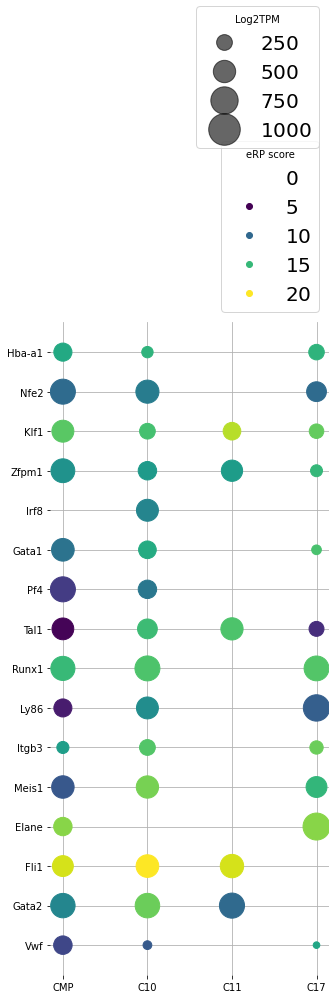

In [43]:
tpm_norm = bubbles['TPM']/bubbles['TPM'].max()
erp_norm = bubbles['eRP']/bubbles['eRP'].max()

fig, ax = plt.subplots(figsize = (5,12))
scatter = ax.scatter(data = bubbles, x = 'pop', y = 'symbol', c = erp_norm*20, s = tpm_norm * 1000, cmap = atac_cmap, vmin = 4.9, vmax = 20)
ax.grid(True)
ax.set_axisbelow(True)
plt.box(on = None)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num = 5), loc="lower right", title="eRP score", bbox_to_anchor=(1, 1), prop={'size': 20})
ax.add_artist(legend1)

# produce a legend with a cross section of sizes from the scatter
handles, labels = scatter.legend_elements(num =5, prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc="upper right", title="Log2TPM", bbox_to_anchor=(1, 1.5), prop={'size': 20})

plt.show()
